In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
from utils_segmentation import *

plots = True

cmap = mpl.colors.ListedColormap(['y', 'r', 'g','w','b','m','c','k'])
norm = mpl.colors.BoundaryNorm([0,1,2,3,4,5,6,7,8], cmap.N)

In [ ]:
noon_thresh = 20#degrees
start_dates_cook = ['20221028224215',
               '20221108180152',
               '20221125231429',
               '20221229191212',
               '20230301223610',
               '20230320171323',
               '20230522171148',
               '20230525222154',
               '20230601192831',
               '20230602184516',
               '20230621202738']

stop_dates_cook =  ['20221104234238',
               '20221116210712',
               '20221229174156',
               '20230221015754',
               '20230301223630',
               '20230322045000',
               '20230525111517',
               '20230601022210',
               '20230602033124',
               '20230621020945',
               '20230718162158']
start_dates_cprl = ['20230411192131',
                    '20230427001305',
                    '20230607014817',
                    '20230623230336']

stop_dates_cprl =  ['20230426231253',
                    '20230531114644',
                    '20230623180307',
                    '20230815182606']

start_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cook]
stop_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cook]

start_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cprl]
stop_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cprl]

In [ ]:
model_mlp_v1 = pickle.load(open(os.path.join(p3,'model_pipeline_V1_mlp_final.pk.sav'), 'rb'))
model_mlp_v2 = pickle.load(open(os.path.join(p3,'model_pipeline_V2_mlp_final.pk.sav'), 'rb'))

cal_nsar_v0 = pickle.load(open(os.path.join(p3,'calibration_nsar1.pk.sav'), 'rb'))#20220705
cal_nsar_v1 = pickle.load(open(os.path.join(p3,'calibration_nsar2.pk.sav'), 'rb'))#20221122
cal_nsar_v2 = pickle.load(open(os.path.join(p3,'calibration_nsar3.pk.sav'), 'rb'))#20230315
[model0,model1,model2,I0,I1] = pickle.load(open(os.path.join(p3,'calibration_nsar_pwlf.pk.sav'), 'rb'))#20230315

cal_cprl = pickle.load(open(os.path.join(p3,'calibration_cprl1.pk.sav'), 'rb'))#20230305

In [ ]:
print('%3.4fx%3.4f'%(cal_cprl.coef_[0][0],cal_cprl.intercept_))
print('%3.4fx%3.4f'%(cal_nsar_v2.coef_[0][0],cal_nsar_v2.intercept_))
print('%3.4fx+%3.4f x<%3.4f'%(model0.coef_[0][0],model0.intercept_,I0))
print('%3.5fx+%3.4f %3.5f<=x<%3.4f'%(model1.coef_[0][0],model1.intercept_,I0,I1))
print('%3.4fx+%3.4f x>=%3.4f'%(model2.coef_[0][0],model2.intercept_,I1))

In [ ]:
for di, start_dates, stop_dates in zip([p0,p00],[start_dates_cook,start_dates_cprl], [stop_dates_cook, stop_dates_cprl]):
    pred_mlp=None
    pred_mlp_noon=None

    lat = np.nan
    lon = np.nan
    ti = 0
    ti_change = True
    imgs=[]
    f_sol_sun = []
    f_sol_shd = []
    f_res_sun = []
    f_res_shd = []
    f_veg_sun = []
    f_veg_shd = []
    f_snw_sun = []
    f_snw_shd = []

    T_sol_sun = []
    T_sol_shd = []
    T_res_sun = []
    T_res_shd = []
    T_veg_sun = []
    T_veg_shd = []
    T_snw_sun = []
    T_snw_shd = []

    elevation = []
    azimuth = []

    times = []
    
    daylight = []

    noon_delta_new = 100
    noon_delta_old = 100
    n_img=0
 
    if di==p00:
        dstXY=np.array([[542,148],[1179.5,127.5],[1197.5,781.5],[533.5,783.5]])
        srcXY=np.array([[48,18],[105.5,17.5],[104.5,76.5],[47.5,76.5]])
        warp_mat = cv2.estimateAffine2D(srcXY,dstXY)
    elif di==p0:
        warp_mat = (np.array([[  7.88031998,   0.28718853,  -6.50989774],
                              [  0.03765769,   7.90500728, -28.32654208]]),
                    np.array([[1],
                              [1],
                              [1],
                              [0]], dtype=np.uint8))
    for version, model in zip(['V2'],[model_mlp_v2]):#zip(['V1','V2'],[model_mlp_v1,model_mlp_v2]):
        f_imgs_ir = list()
        f_imgs_bgr = list()
        utc_ir = list()
        utc_bgr = list()
        for f in os.listdir(os.path.join(di,version)):
            if '.png' in f:

                time_place = f.split('.png')[0].split('_')
                if version=='V1': 
                    t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                elif version=='V2':
                    if di==p0:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                    elif di==p00:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                if '_bgr' in f:
                    f_imgs_bgr.append(f)
                    utc_bgr.append(t_meas)
                if '_ir' in f:
                    f_imgs_ir.append(f)
                    utc_ir.append(t_meas)

        ibgr = np.argsort(utc_bgr)
        iir = np.argsort(utc_ir)
        utc_bgr = np.array(utc_bgr)[ibgr]
        utc_ir = np.array(utc_ir)[iir]
        f_imgs_bgr = np.array(f_imgs_bgr)[ibgr]
        f_imgs_ir = np.array(f_imgs_ir)[iir]

        #find closest IR match to BGR
        idx = []
        for utc, f in zip(utc_bgr,f_imgs_bgr):
            idx.append(np.argmin(np.abs(utc_ir-utc)))

        utc_ir = np.array(utc_ir)[idx]
        f_imgs_ir = np.array(f_imgs_ir)[idx]
        for f_bgr, f_ir in zip(f_imgs_bgr,f_imgs_ir):
            #print(f_bgr)
            bgr = cv2.imread(os.path.join(di,version,f_bgr),cv2.IMREAD_UNCHANGED)
            #filter nighttime
            #20221017084722_-117.081903_46.781495_bgr.png
            time_place = f_bgr.split('_bgr.')[0].split('_')
            if version=='V1':
                utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            elif version=='V2':
                if di==p0:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                elif di==p00:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            if utc>=start_dates[ti] and utc<=stop_dates[ti]: 
                theta = np.nan
                phi = np.nan
                if version == 'V1':
                    if 'nofix' not in time_place:
                        lat = np.double(time_place[2])
                        lon = np.double(time_place[1])
                    elif 'nofix' in time_place and di==p00:
                        #Latitude: 35 ° 11’ 17.45”; Longitude: 102° 5’ 43.98”; elevation : 1168 m
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                elif version == 'V2':
                    if di == p0:
                        lat = 46.781553
                        lon = -117.081863
                    elif di == p00:
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                else:
                    pass
                theta = solar.get_altitude(lat,lon,utc)
                phi = solar.get_azimuth(lat,lon,utc)
                print(utc,phi,theta)
                day = False
                _,_,v = cv2.split(cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV))
                if theta>10.0:
                    day = True
                    feat,_ = get_features(bgr)

                    if not np.any(np.isnan(feat)):
                        pred_mlp = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
                        if plots and n_img%250==0:
                            plt.imshow(bgr)
                            plt.title('bgr')
                            plt.savefig(os.path.join(p3,di.split('\\')[-1].lower()+version+'_'+datetime.strftime(utc,'%Y%m%d%H%M%S')
+'_bgr.png'),dpi=300)
                            plt.show()

                            plt.imshow(pred_mlp, cmap=cmap, norm=norm, interpolation='none')
                            plt.title('labels')
                            plt.savefig(os.path.join(p3,di.split('\\')[-1].lower()+version+'_'+datetime.strftime(utc,'%Y%m%d%H%M%S')
+'_lab.png'),dpi=300)
                            plt.show()
                    
                    ir_good = False 
                    if os.path.getsize(os.path.join(di,version,f_ir))>10000:
                        ir_raw = cv2.imread(os.path.join(di,version,f_ir),cv2.IMREAD_UNCHANGED)
                        
                        if np.std(ir_raw)<1000:
                            ir_good = True
                        else:
                            ir_good = False
                    if ir_good:
                        if di==p0:
                            if utc<start_dates[6] and ti_change:
                                print(utc)
                                #calculate affine - camera shift - get mask
                                try:
                                    warp_mat,_ = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=None)
                                except:
                                    pass
                                
                                mask = (pred_mlp==3) | (pred_mlp==7)
                        elif di==p00:
                            if utc<=start_dates[3] and utc>=stop_dates[2]:
                                print(utc)
                                #calculate affine - camera shift - get mask
                                #warp_mat,_ = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=None)
                                mask = (pred_mlp==3) | (pred_mlp==7)
                        _,ir = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=warp_mat)
                        T_ir = ir.astype(np.float)
                        
                        
                        #
                        T_ir = np.piecewise(T_ir, [T_ir < I0, (T_ir>=I0) & (T_ir<I1), T_ir>=I1], [lambda x: model0.intercept_[0]+model0.coef_[0][0]*x, lambda x: model1.intercept_[0]+model1.coef_[0][0]*x, lambda x: model2.intercept_[0]+model2.coef_[0][0]*x])
                        if di==p0:
                            if utc<start_dates[6]:
                                T_ir[mask] = np.nan
                                pred_mlp[mask] = np.nan
                        elif di==p00:
                        #     T_ir = T_ir*cal_cprl.coef_+cal_cprl.intercept_
                        
                            if utc<=start_dates[3] and utc>=stop_dates[2]:
                                T_ir[mask] = np.nan
                                pred_mlp[mask] = np.nan      
                                
                        T_ir[T_ir==model0.intercept_] = np.nan
                        T_ir = T_ir*(1/.98)**(1/4)
                        if plots and n_img%250==0:
                            plt.imshow(T_ir)
                            plt.colorbar()
                            plt.savefig(os.path.join(p3,di.split('\\')[-1].lower()+version+'_'+datetime.strftime(utc,'%Y%m%d%H%M%S')
+'_tir.png'),dpi=300)
                            plt.show()
                    else:
                        T_ir = np.nan*v.reshape(bgr.shape[0:2])

                    noon_delta_new = np.abs(theta-90) 
                    if noon_delta_new<noon_delta_old:#near noon
                        print('noon')
                        pred_mlp_noon=pred_mlp.copy()
                    noon_delta_old = noon_delta_new

                    f_sol_sun.append(np.nansum(pred_mlp==0)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    f_sol_shd.append(np.nansum(pred_mlp==4)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    f_res_sun.append(np.nansum(pred_mlp==1)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    f_res_shd.append(np.nansum(pred_mlp==5)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    f_veg_sun.append(np.nansum(pred_mlp==2)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    f_veg_shd.append(np.nansum(pred_mlp==6)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    f_snw_sun.append(np.nansum(pred_mlp==3)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    f_snw_shd.append(np.nansum(pred_mlp==7)/pred_mlp.shape[0]/pred_mlp.shape[1])
                    
                    T_sol_sun.append(np.nanmean(T_ir[pred_mlp==0]))
                    T_sol_shd.append(np.nanmean(T_ir[pred_mlp==4]))
                    T_res_sun.append(np.nanmean(T_ir[pred_mlp==1]))
                    T_res_shd.append(np.nanmean(T_ir[pred_mlp==5]))
                    T_veg_sun.append(np.nanmean(T_ir[pred_mlp==2]))
                    T_veg_shd.append(np.nanmean(T_ir[pred_mlp==6]))
                    T_snw_sun.append(np.nanmean(T_ir[pred_mlp==3]))
                    T_snw_shd.append(np.nanmean(T_ir[pred_mlp==7]))
                    daylight.append(day)
                else:#night 

                    if pred_mlp_noon is not None:

                        ir_good = False

                        if os.path.getsize(os.path.join(di,version,f_ir))>10000:
                            ir_raw = cv2.imread(os.path.join(di,version,f_ir),cv2.IMREAD_UNCHANGED)
                            if np.std(ir_raw)<1000:
                                ir_good = True
                            else:
                                ir_good = False
                        if ir_good:
                            _,ir = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=warp_mat)
                            T_ir = ir.astype(np.float)
                            #
                            T_ir = np.piecewise(T_ir, [T_ir < I0, (T_ir>=I0) & (T_ir<I1), T_ir>=I1], [lambda x: model0.intercept_[0]+model0.coef_[0][0]*x, lambda x: model1.intercept_[0]+model1.coef_[0][0]*x, lambda x: model2.intercept_[0]+model2.coef_[0][0]*x])
                            if di==p0:
                                if utc<start_dates[6]:
                                    T_ir[mask] = np.nan
                                    pred_mlp_noon[mask] = np.nan
                            elif di==p00:
                            #     T_ir = T_ir*cal_cprl.coef_+cal_cprl.intercept_
                            
                                if utc<=start_dates[3] and utc>=stop_dates[2]:
                                    T_ir[mask] = np.nan
                                    pred_mlp_noon[mask] = np.nan      
                                    
                            T_ir[T_ir==model0.intercept_] = np.nan
                            T_ir = T_ir*(1/.98)**(1/4)
                        else:
                            T_ir = np.nan*v.reshape(bgr.shape[0:2])

                        f_sol_sun.append(0)
                        f_sol_shd.append(np.nansum(np.logical_or(pred_mlp_noon==4,pred_mlp_noon==0))/pred_mlp_noon.shape[0]/pred_mlp_noon.shape[1])
                        f_res_sun.append(0)
                        f_res_shd.append(np.nansum(np.logical_or(pred_mlp_noon==5,pred_mlp_noon==1))/pred_mlp_noon.shape[0]/pred_mlp_noon.shape[1])
                        f_veg_sun.append(0)
                        f_veg_shd.append(np.nansum(np.logical_or(pred_mlp_noon==6,pred_mlp_noon==2))/pred_mlp_noon.shape[0]/pred_mlp_noon.shape[1])
                        f_snw_sun.append(0)
                        f_snw_shd.append(np.nansum(np.logical_or(pred_mlp_noon==7,pred_mlp_noon==3))/pred_mlp_noon.shape[0]/pred_mlp_noon.shape[1])

                        T_sol_sun.append(np.nan)
                        T_sol_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp_noon==4,pred_mlp_noon==0)]))
                        T_res_sun.append(np.nan)
                        T_res_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp_noon==5,pred_mlp_noon==1)]))
                        T_veg_sun.append(np.nan)
                        T_veg_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp_noon==6,pred_mlp_noon==2)]))
                        T_snw_sun.append(np.nan)
                        T_snw_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp_noon==7,pred_mlp_noon==3)]))
                    else:
                        f_sol_sun.append(np.nan)
                        f_sol_shd.append(np.nan)
                        f_res_sun.append(np.nan)
                        f_res_shd.append(np.nan)
                        f_veg_sun.append(np.nan)
                        f_veg_shd.append(np.nan)
                        f_snw_sun.append(np.nan)
                        f_snw_shd.append(np.nan)

                        T_sol_sun.append(np.nan)
                        T_sol_shd.append(np.nan)
                        T_res_sun.append(np.nan)
                        T_res_shd.append(np.nan)
                        T_veg_sun.append(np.nan)
                        T_veg_shd.append(np.nan)
                        T_snw_sun.append(np.nan)
                        T_snw_shd.append(np.nan)
                    daylight.append(day)
                elevation.append(90-theta)
                azimuth.append(phi)

                times.append(utc)

                n_img=n_img+1
                ti_change = False
            
            elif utc>stop_dates[ti] and utc<stop_dates[-1]:
                ti = ti+1
                ti_change = True
    df = pd.DataFrame(data={'times':times,'daylight':daylight,'elevation':elevation,'azimuth':azimuth,'fssun':f_sol_sun,'fsshd':f_sol_shd,'frsun':f_res_sun,'frshd':f_res_shd,'fvsun':f_veg_sun,'fvshd':f_veg_shd,'fwsun':f_snw_sun,'fwshd':f_snw_shd,'Tssun':T_sol_sun,'Tsshd':T_sol_shd,'Trsun':T_res_sun,'Trshd':T_res_shd,'Tvsun':T_veg_sun,'Tvshd':T_veg_shd,'Twsun':T_snw_sun,'Twshd':T_snw_shd})
    df.to_csv(os.path.join(p3,di.split('\\')[-1].lower()+version+'_output.csv'))

In [162]:
cook_hy2023_v1 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cookhy2023V1_output.csv')
cook_hy2023_v2 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cookhy2023V2_output.csv')
cprl_hy2023_v1 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cprlhy2023V1_output.csv')
cprl_hy2023_v2 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cprlhy2023V2_output.csv')
cprl_hy2023_irt = pd.read_csv('E:/usda/raw/CookIRCamET/Meteorological/Cprl/ne_lys_simple.csv')

In [163]:
cprl_hy2023_v1['times']=pd.to_datetime(cprl_hy2023_v1['times'],format='%Y-%m-%d %H:%M:%S')
cprl_hy2023_v2['times']=pd.to_datetime(cprl_hy2023_v2['times'],format='%Y-%m-%d %H:%M:%S')
cook_hy2023_v1['times']=pd.to_datetime(cook_hy2023_v1['times'],format='%Y-%m-%d %H:%M:%S')
cook_hy2023_v2['times']=pd.to_datetime(cook_hy2023_v2['times'],format='%Y-%m-%d %H:%M:%S')

In [164]:
cprl_hy2023_irt['times'] = cprl_hy2023_irt.apply(lambda p: pytz.utc.localize(datetime.strptime(p.Date+' '+str((p.Hour+5)%24)+':'+str(p.Minute),'%m/%d/%Y %H:%M')),axis=1)

In [175]:
cprl_hy2023_irt['Dry Soil IRT']=cprl_hy2023_irt['Dry Soil IRT']+273.15

In [176]:
xlim=[pd.to_datetime('2023-05-01 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-05-15 00:00:00',format='%Y-%m-%d %H:%M:%S')]

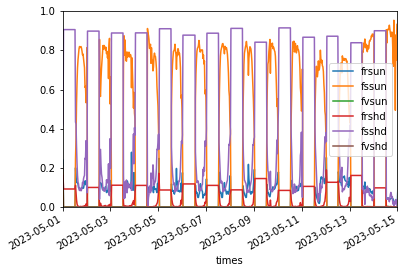

In [177]:
fig=cprl_hy2023_v1.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=xlim,ylim=[0,1])
fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v1_f.png'),dpi=300)

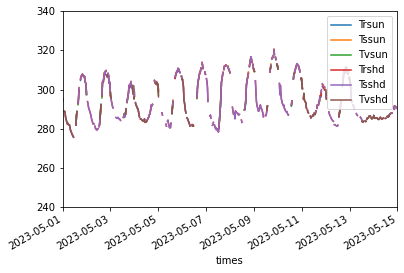

In [178]:
fig=cprl_hy2023_v1.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[240,340])
fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v1_t.png'),dpi=300)

In [179]:
xlim=[pd.to_datetime('2022-12-13 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2022-12-29 00:00:00',format='%Y-%m-%d %H:%M:%S')]

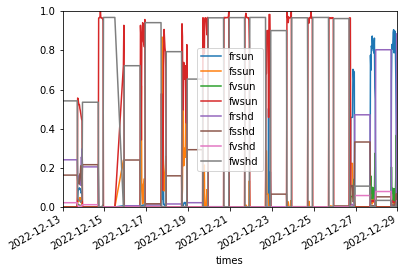

In [180]:
fig=cook_hy2023_v1.plot(x='times',y=['frsun','fssun','fvsun','fwsun','frshd','fsshd','fvshd','fwshd'],xlim=xlim,ylim=[0,1])
fig.get_figure().savefig(os.path.join(p3,'cook_hy2023_v1_f.png'),dpi=300)

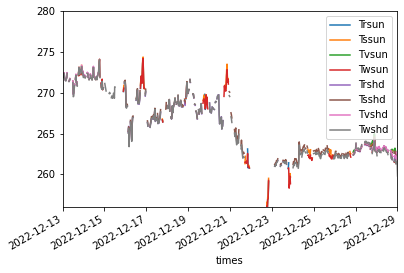

In [181]:
fig=cook_hy2023_v1.plot(x='times',y=['Trsun','Tssun','Tvsun','Twsun','Trshd','Tsshd','Tvshd','Twshd'],xlim=xlim,ylim=[256,280])
fig.get_figure().savefig(os.path.join(p3,'cook_hy2023_v1_t.png'),dpi=300)

In [204]:
xlim=[pd.to_datetime('2023-7-15 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-7-25 00:00:00',format='%Y-%m-%d %H:%M:%S')]

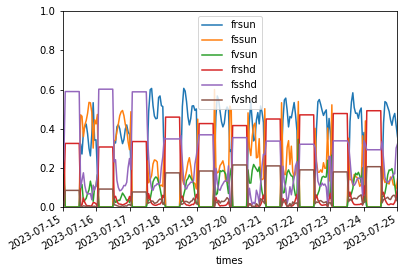

In [205]:
fig=cprl_hy2023_v2.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=xlim,ylim=[0,1])
fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v2_f.png'),dpi=300)

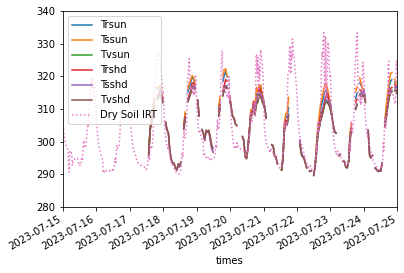

In [206]:
ax = cprl_hy2023_v2.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[240,340])
#fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v2_t.png'),dpi=300)
fig=cprl_hy2023_irt.plot(ax=ax,x='times',y=['Dry Soil IRT'],xlim=xlim,ylim=[280,340],linestyle=':')
fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v2_irt.png'),dpi=300)
plt.show()

In [192]:
cprl_hy2023_irt.times

0     2023-07-15 05:00:00+00:00
1     2023-07-15 05:15:00+00:00
2     2023-07-15 05:30:00+00:00
3     2023-07-15 05:45:00+00:00
4     2023-07-15 06:00:00+00:00
                 ...           
955   2023-07-24 03:45:00+00:00
956   2023-07-24 04:00:00+00:00
957   2023-07-24 04:15:00+00:00
958   2023-07-24 04:30:00+00:00
959   2023-07-24 04:45:00+00:00
Name: times, Length: 960, dtype: datetime64[ns, UTC]

In [193]:
xlim=[pd.to_datetime('2023-06-15 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-06-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]

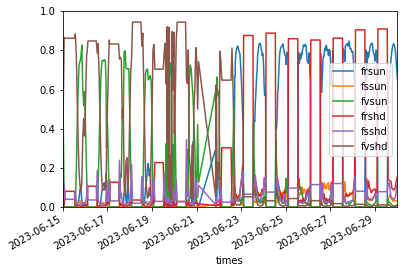

In [187]:
fig=cook_hy2023_v2.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=xlim,ylim=[0,1])
fig.get_figure().savefig(os.path.join(p3,'cook_hy2023_v2_f.png'),dpi=300)

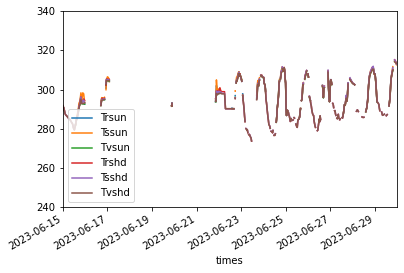

In [188]:
fig=cook_hy2023_v2.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[240,340])
fig.get_figure().savefig(os.path.join(p3,'cook_hy2023_v2_t.png'),dpi=300)